In [1]:
import pandas as pd 
import numpy as np

In [2]:
import random

random.seed(0)

In [3]:
import warnings
warnings.filterwarnings('ignore')

1. Выберите алгоритм обучения с учителем с большим числом гиперпараметров.

In [4]:
from sklearn.ensemble import RandomForestClassifier

In [5]:
main_model = RandomForestClassifier

2. Выберите набор данных и целевую функцию оценки алгоритма.

In [6]:
from sklearn.metrics import precision_score

In [7]:
import os
from scipy.io import arff
from scipy.io.arff import ParseArffError

In [8]:
to_file = ''

In [9]:
df_name = '8.arff'

In [10]:
first_arff, meta = arff.loadarff(to_file+df_name)

In [11]:
meta

Dataset: liver-disorders
	mcv's type is numeric
	alkphos's type is numeric
	sgpt's type is numeric
	sgot's type is numeric
	gammagt's type is numeric
	drinks's type is numeric
	selector's type is nominal, range is ('1', '2')

In [12]:
meta.types()

['numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'nominal']

In [13]:
meta.names()

['mcv', 'alkphos', 'sgpt', 'sgot', 'gammagt', 'drinks', 'selector']

In [14]:
first_arff
;

''

In [15]:
df = pd.DataFrame(data=first_arff, columns=meta.names())

In [16]:
df['selector'] = df['selector'].astype(int)

In [17]:
df

,mcv,alkphos,sgpt,sgot,gammagt,drinks,selector
0,85.0,92.0,45.0,27.0,31.0,0.0,1
1,85.0,64.0,59.0,32.0,23.0,0.0,2
2,86.0,54.0,33.0,16.0,54.0,0.0,2
3,91.0,78.0,34.0,24.0,36.0,0.0,2
4,87.0,70.0,12.0,28.0,10.0,0.0,2
...,...,...,...,...,...,...,...
340,99.0,75.0,26.0,24.0,41.0,12.0,1
341,96.0,69.0,53.0,43.0,203.0,12.0,2
342,98.0,77.0,55.0,35.0,89.0,15.0,1
343,91.0,68.0,27.0,26.0,14.0,16.0,1


In [18]:
target = 'selector'

Изучите характеристики ваших данных, исследуйте различные аспекты задачи, такие как количество признаков, баланс классов и тип задачи (классификация или регрессия).

Задача бинарной классификации заболевания печени, 

6 признаков: показатели из анализа крови, первые 5 - int, 6 ой Real 345 записей

Пропусков в данных нет

Attribute information:
1. mcv	mean corpuscular volume
2. alkphos	alkaline phosphotase
3. sgpt	alamine aminotransferase
4. sgot 	aspartate aminotransferase
5. gammagt	gamma-glutamyl transpeptidase
6. drinks	number of half-pint equivalents of alcoholic beverages drunk per day
7. selector  field used to split data into two sets

Все значения не превышают 300

Значения в первых четырех столбцах не превышает 100

Значения в пятом столбце в основном меньше 100, но там есть 107, 150, 250

В таргете значения 1 и 2

1 - 145

2 - 200

всего 345

3. Реализуйте алгоритм байесовской оптимизации

In [19]:
data_size = df.shape[0]
features = df.shape[1]
features

7

In [20]:
# param_dist = {
#     'n_estimators': (1, 1000),
#     'max_depth': (1, data_size),
#     'min_samples_split':(2, data_size),
#     'min_samples_leaf': (1, data_size),
#     'max_features': (1, features-1),
#     'max_leaf_nodes': (2, data_size)
# }

In [21]:
param_dist = {
    'n_estimators': (1, 5),
    'max_depth': (1, 2),
    'min_samples_split':(2, 3),
    'min_samples_leaf': (1, 2),
    'max_features': (1, features-1),
    'max_leaf_nodes': (2, 3)
}
# В мире продакшена принято делить данные на числовые и категориальные признаки https://your-scorpion.ru/log-loss-pca/

3. Реализуйте алгоритм байесовской оптимизации.

In [22]:
from sklearn.model_selection import train_test_split

def check_model(model):
    
    X_train, X_test, y_train, y_test = train_test_split(df.drop(target, axis = 1), df[target])
    model.fit(X_train, y_train)
    return precision_score(y_test, model.predict(X_test), average='micro')

In [23]:
def generate_hyp(d):
    ans_d = {}
    for key in d:
        start_end = d[key]
        
        yield ans_d

In [24]:
def genNumber(start, end):
    for num in range(start, end+1):
        yield num

In [25]:
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
from math import sqrt, log

In [26]:
class BayesianOptimization:
    def __init__(self):
        self.observations_df = pd.DataFrame()
        self.model = GaussianProcessRegressor(random_state=0)
    
    def fitt(self):
        self.model.fit(self.observations_df.drop('score', axis=1), 
                       self.observations_df[['score']])
    
    def check_observ(self, observ:dict):
        score = check_model(main_model(**observ))
        observ['score'] = score
        hy_series = pd.Series(observ)
    
        self.observations_df = pd.concat([self.observations_df, hy_series.to_frame().T], ignore_index=True)
        self.fitt()
        return score
    
    def find_new_observ(self):
        maxx = -1
        maxx_params = {} #Dict
        for n0 in range(param_dist['n_estimators'][0], param_dist['n_estimators'][1]+1):
            observ = {} 
            observ['n_estimators'] = n0
            for n1 in range(param_dist['max_depth'][0], param_dist['max_depth'][1]+1):
                observ['max_depth'] = n1
                for n2 in range(param_dist['min_samples_split'][0], param_dist['min_samples_split'][1]+1):
                    observ['min_samples_split'] = n2
                    for n3 in range(param_dist['min_samples_leaf'][0], param_dist['min_samples_leaf'][1]+1):
                        observ['min_samples_leaf'] = n3
                        for n4 in range(param_dist['max_features'][0], param_dist['max_features'][1]+1):
                            observ['max_features'] = n4
                            for n5 in range(param_dist['max_leaf_nodes'][0], param_dist['max_leaf_nodes'][1]+1):
                                observ['max_leaf_nodes'] = n5
                                predicted_score, st_div = self.model.predict(pd.Series(observ).to_frame().T, return_std=True)
                                f = predicted_score[0] + sqrt(3/2 * log(self.observations_df.shape[0] + 1)) * st_div[0]
                                # f = 0.5
                                if (maxx < f):
                                    maxx = f
                                    maxx_params = observ
                                    # print(f'{maxx} {f}')
                                    # print(maxx_params)
        # generators = []
        # for key in param_dist:
        #     start_end = param_dist[key]
        #     generators.append(genNumber(start_end[0], start_end[1]))
        
#         for n0 in generators[0]:
#             observ = {} 
#             observ['n_estimators'] = n0
#             for n1 in generators[1]:
#                 observ['max_depth'] = n1
#                 for n2 in generators[2]:
#                     observ['min_samples_split'] = n2
#                     for n3 in generators[3]:
#                         observ['min_samples_leaf'] = n3
#                         for n4 in generators[4]:
#                             observ['max_features'] = n4
#                             for n5 in generators[5]:
#                                 observ['max_leaf_nodes'] = n5
                                
#                                 predicted_score, st_div = self.model.predict(pd.Series(observ).to_frame().T, return_std=True)
#                                 # print(len(st_div))
#                                 # print(self.observations_df.shape)
#                                 f = predicted_score[0] + sqrt(3/2 * log(self.observations_df.shape[0] + 1)) * st_div[0]
#                                 # f = 0.5
#                                 if (maxx < f):
#                                     maxx = f
#                                     maxx_params = observ
        return maxx_params

In [27]:
bayes = BayesianOptimization()

In [28]:
class RandomParamSearch:
    def __init__(self, params):
        self.params = params
    
    def get_combination(self):
        ans_dict = {}
        for i in self.params:
            ans_dict[i] = random.randint(self.params[i][0], self.params[i][1])
        return ans_dict

In [29]:
best_bayes=[0]
best_score = 0

In [30]:
r1 = RandomParamSearch(param_dist)
for i in range(15):
    sc = bayes.check_observ(r1.get_combination())
    if (best_score < sc):
        best_score = sc
    best_bayes.append(best_score)

In [31]:
# bayes.find_new_observ()

In [32]:

for i in range(100):
    obs = bayes.find_new_observ()
    score = bayes.check_observ(obs)
    if score > best_score:
        best_score = score
    best_bayes.append(best_score)
    if i % 10 == 0:
        print(f'{i} {score}')
print(best_score)

0 0.5517241379310345
10 0.5287356321839081
20 0.6666666666666666
30 0.5862068965517241
40 0.6551724137931034
50 0.5287356321839081
60 0.5862068965517241
70 0.7126436781609196
80 0.5977011494252874
90 0.5747126436781609
0.7701149425287356


4. Сравните алгоритм байесовской оптимизации со случайным поиском.


In [33]:
random_search = RandomParamSearch(param_dist)

In [34]:
best_random=[0]

In [35]:
best_params = None 
best_score = 0
random_history_iteration = []
random_history_hypers = []
random_history_score = []

hyper_df = pd.DataFrame()

In [36]:
for i in range(115):
    hyper_params = random_search.get_combination();
    score = check_model(main_model(**hyper_params))
    hyper_params['score'] = score
    hyper_series = pd.Series(hyper_params)
    
    hyper_df = pd.concat([hyper_df, hyper_series.to_frame().T], ignore_index=True)
    
    if score > best_score:
        best_score = score
        best_params = hyper_params
    if i % 10 == 0:
        print(f'{i} {score}')
    best_random.append(best_score)
print(best_score)
print(best_params)

0 0.5977011494252874
10 0.6436781609195402
20 0.6551724137931034
30 0.6666666666666666
40 0.6551724137931034
50 0.5057471264367817
60 0.5287356321839081
70 0.5747126436781609
80 0.6436781609195402
90 0.6436781609195402
100 0.5632183908045977
110 0.632183908045977
0.7126436781609196
{'n_estimators': 5, 'max_depth': 1, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 6, 'max_leaf_nodes': 3, 'score': 0.7126436781609196}


In [37]:
hyper_df

,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,max_leaf_nodes,score
0,5.0,1.0,2.0,2.0,5.0,3.0,0.597701
1,4.0,2.0,3.0,1.0,3.0,2.0,0.597701
2,4.0,2.0,2.0,1.0,1.0,3.0,0.528736
3,1.0,1.0,3.0,1.0,3.0,3.0,0.482759
4,1.0,1.0,2.0,1.0,1.0,2.0,0.540230
...,...,...,...,...,...,...,...
110,3.0,2.0,2.0,1.0,5.0,3.0,0.632184
111,2.0,1.0,3.0,2.0,6.0,3.0,0.586207
112,4.0,1.0,3.0,2.0,6.0,3.0,0.563218
113,2.0,2.0,2.0,2.0,2.0,2.0,0.551724


5. Визуализируйте пространство протестированных значений гиперпараметров. Цветом обозначьте значение целевой функции на них.

In [38]:
from sklearn.decomposition import PCA
def vis(df):
    pca = PCA(n_components=2)
    params_2d = pca.fit_transform(df.drop('score', axis = 1))
    ans_df = pd.DataFrame(data = params_2d, columns=['component1', 'component2'])
    return ans_df

In [39]:
vis(hyper_df)

,component1,component2
0,-2.197519,1.142630
1,0.105418,1.159721
2,1.849625,2.072971
3,1.406187,-1.592599
4,3.218780,-0.669793
...,...,...
110,-1.293875,-0.586909
111,-1.757334,-2.016688
112,-2.639002,-0.228220
113,1.834967,-0.146220


In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
def d2(df):
    pca2D_df = vis(df)
    plt.scatter(pca2D_df.component1, pca2D_df.component2, c=hyper_df.score, cmap='viridis')
    plt.title("PCA")
    plt.show()

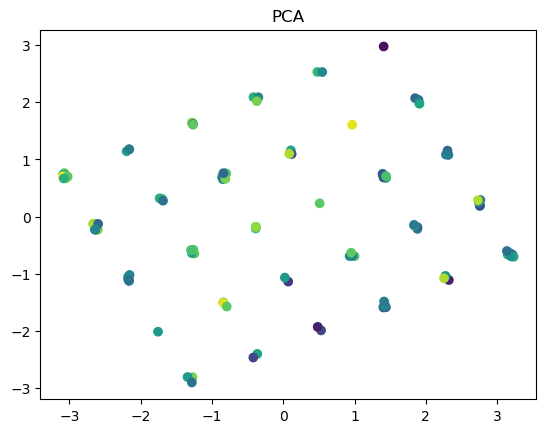

In [42]:
pca2D_df = vis(hyper_df)
plt.scatter(pca2D_df.component1, pca2D_df.component2, c=hyper_df.score, cmap='viridis')
plt.title("PCA")
plt.show()

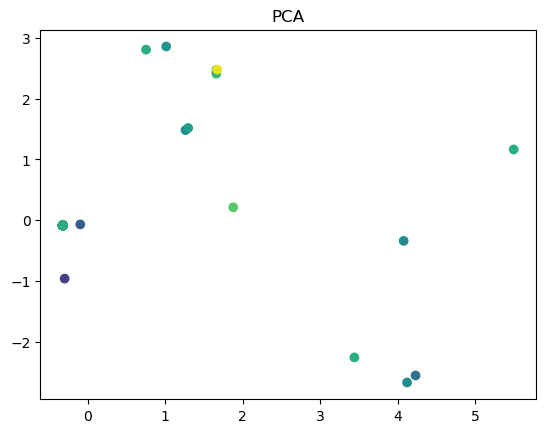

In [43]:
pca2D_df = vis(bayes.observations_df)
plt.scatter(pca2D_df.component1, pca2D_df.component2, c=bayes.observations_df.score, cmap='viridis')
plt.title("PCA")
plt.show()

In [44]:
pca2D_df = vis(hyper_df)
pca2D_df

,component1,component2
0,-2.197519,1.142630
1,0.105418,1.159721
2,1.849625,2.072971
3,1.406187,-1.592599
4,3.218780,-0.669793
...,...,...
110,-1.293875,-0.586909
111,-1.757334,-2.016688
112,-2.639002,-0.228220
113,1.834967,-0.146220


6. Визуализируйте значение целевой функции в зависимости от номера шага.

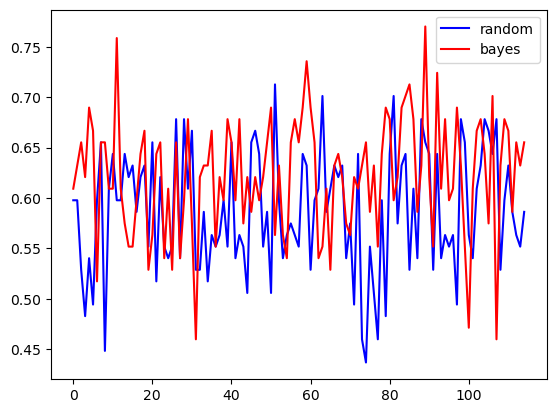

In [45]:
plt.plot(hyper_df['score'], color='blue')
plt.plot(bayes.observations_df['score'], color='red')
plt.legend(['random', 'bayes'])
plt.show()

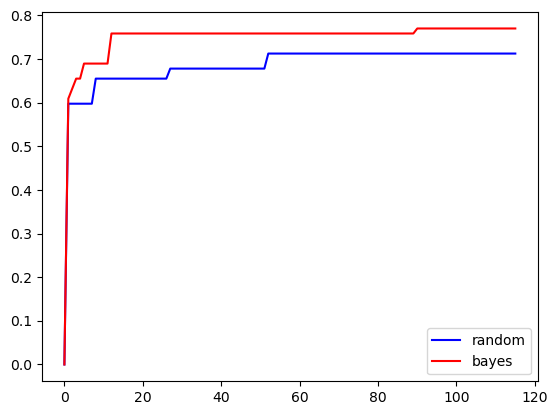

In [46]:
plt.plot(best_random, color='blue')
plt.plot(best_bayes, color='red')
plt.legend(['random', 'bayes'])
plt.show()

In [47]:
print(best_random[-1])
print(best_bayes[-1])

0.7126436781609196
0.7701149425287356
